In [ ]:
#function to predict image label
from tensorflow.keras.preprocessing import image

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

def predict_image_class(model, images, show = True):
  class_label=''
  for img in images:
    #preprocess images according to model specifications
    img = image.load_img(img, target_size=(299, 299))
    img = image.img_to_array(img)                    
    img = np.expand_dims(img, axis=0)         
    img /= 255.                                      
    foods_sorted =['cup_cakes','donuts','dumplings','garlic_bread','ice_cream','nachos','onion_rings','pizza','samosa','steak','sushi','waffles','cheesecake']
    pred = model.predict(img)
    index = np.argmax(pred)
    foods_sorted.sort()
    pred_value = foods_sorted[index]
    if show:
        plt.imshow(img[0])                           
        plt.axis('off')
        plt.title(pred_value)
        plt.show()
    class_label=pred_value
  return class_label

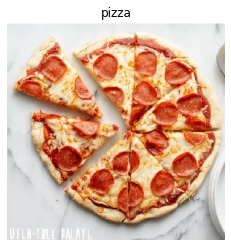

In [ ]:
#load Inception model and make predictions
#add paths to images to be classified below
from tensorflow.keras.models import load_model
model=load_model('model_Inception.hdf5')
images = []

images.append('pizza.png')
class_label = predict_image_class(model, images, True)

In [ ]:
#Loading the processed dataset

data = pd.read_csv('processed_data.csv')
# data.head()

In [ ]:
#Fitting tf-ift vectorizer to find cosine similarity 

from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer(use_idf=False, norm='l2') #cosine similarity
X = vec.fit_transform(data['ingredients_stem'])



In [ ]:
#function to compute cosine similarity

from  sklearn.metrics.pairwise import cosine_similarity
def get_cosine_similarity(list1, list2):
    s1= vec.transform(list1)
    s2 = vec.transform(list2)
    return cosine_similarity(s1,s2)

In [ ]:
# Fetching titles with class_label name

selected_df = data[data['title'].str.lower().str.contains('pizza') & data['ingredients_count']>0].sort_values(by='ingredients_count')
print(selected_df.shape)
# selected_df

(67, 14)


In [ ]:
#Fetching cluster label of recurring cluster 

cluster_label = (selected_df.groupby('labels').count()['ingredients_stem']).sort_values()[-1:].index[0]
cluster_label

9

In [ ]:
# Filtering data to get a dataset containing similary cluster items of previously fetched cluster label

similar_df = data[data['labels']==cluster_label]
similar_df

,directions,fat,categories,calories,desc,protein,title,ingredients,sodium,ingredients_list,ingredients_count,ingredients_doc,ingredients_stem,labels
3,['Heat oil in heavy large skillet over medium-...,NaN,"['Fish', 'Olive', 'Tomato', 'Sauté', 'Low Fat'...",NaN,The Sicilian-style tomato sauce has tons of Me...,NaN,Mahi-Mahi in Tomato Olive Sauce,"['2 tablespoons extra-virgin olive oil', '1 cu...",NaN,"['extra-virgin olive oil', 'fillets', 'white b...",11,extra-virgin olive oil fillets white bread dic...,extra-virgin oliv oil fillet white bread dice ...,9
23,['Heat oil in heavy large skillet over medium ...,NaN,"['Milk/Cream', 'Cheese', 'Leafy Green', 'Pasta...",NaN,NaN,NaN,Pancetta and Taleggio Lasagna with Treviso,"['3 tablespoons extra-virgin olive oil', '8 ou...",NaN,"['bacon', 'italian bread', 'taleggio', 'extra-...",22,bacon italian bread taleggio extra-virgin oliv...,bacon italian bread taleggio extra-virgin oliv...,9
31,"['Blanch 6 lemons in boiling water 5 minutes, ...",NaN,"['Lemon', 'Boil', 'Gourmet', 'Australia']",NaN,Preserved lemons are perhaps most at home in M...,NaN,Moroccan-Style Preserved Lemons,"['10 to 12 lemons (2 1/2 to 3 lb)', '2/3 cup k...",NaN,"['kosher salt', 'extra-virgin olive oil', 'lem...",3,kosher salt extra-virgin olive oil lemons,kosher salt extra-virgin oliv oil lemon,9
32,['Put oven rack in upper third of oven and pre...,18.0,"['Onion', 'Side', 'Roast', 'Thanksgiving', 'Vi...",376.0,Don't be surprised if these spears prove even ...,7.0,Roasted Sweet-Potato Spears with Bacon Vinaigr...,"['4 pounds medium sweet potatoes (about 7)', '...",604.0,"['bacon', 'extra-virgin olive oil', 'sweet pot...",10,bacon extra-virgin olive oil sweet potatoes wa...,bacon extra-virgin oliv oil sweet potato water...,9
36,"['Whisk flour, salt, and yeast in medium bowl ...",NaN,"['Dessert', 'White Wine', 'Family Reunion', 'D...",NaN,Donatella still remembers the lure of these ad...,NaN,Pastry Twists with Spiced Sugar-Honey Glaze,"['1 1/2 cups all purpose flour', '1/4 teaspoon...",NaN,"['active dry yeast', 'extra-virgin olive oil',...",12,active dry yeast extra-virgin olive oil ground...,activ yeast extra-virgin oliv oil nutmeg flou...,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17663,['Peel potatoes and cut into 1-inch pieces. In...,8.0,"['Soup/Stew', 'Cheese', 'Potato', 'Vegetable',...",329.0,Can be prepared in 45 minutes or less.,12.0,Broccoli Potato Soup with Parmesan Croutons,"['1 3/4 pounds boiling potatoes', '2 garlic cl...",317.0,"['broccoli', 'water', 'italian bread', 'extra-...",8,broccoli water italian bread extra-virgin oliv...,broccoli water italian bread extra-virgin oliv...,9
17664,['Cook pasta in an 8-quart pot of boiling salt...,21.0,"['Pasta', 'Quick & Easy', 'Parmesan', 'Lemon',...",666.0,NaN,29.0,Pasta with Arugula and Prosciutto,"['1 lb penne (preferably ridged)', '1/4 lb thi...",948.0,"['extra-virgin olive oil', 'lemon zest', 'arug...",8,extra-virgin olive oil lemon zest arugula penn...,extra-virgin oliv oil lemon zest arugula penn ...,9
17668,['1. Preheat the oven to 450°F. Lightly oil a ...,12.0,"['Garlic', 'Shellfish', 'Bake', 'Quick & Easy'...",251.0,Gamberi Aragonati,18.0,Shrimp with Garlic and Toasted Bread Crumbs,"['1 cup fresh bread crumbs, made from Italian ...",826.0,"['lemon wedge', 'clove', 'leaf parsley', 'grou...",9,lemon wedge clove leaf parsley ground black pe...,lemon wedg clove leaf parsley black pepper ga...,9
17675,['Bring vermouth and raisins to a boil in a sm...,152.0,"['Mustard', 'Roast', 'Easter', ""Mother's Day"",...",1782.0,"Your subconscious will register ""early spring""...",81.0,Rack of Lamb with Swiss Chard,"['1/2 cup sweet (red) vermouth', '1/2 cup gold...",456.0,"['golden raisins', 'extra-virgin olive oil', '...",17,golden raisins extra-virgin olive oil hen toas...,golden raisin extra-virgin oliv oil hen toast ...,9


In [ ]:
# Fetching recipe for predicted class label

item = similar_df[similar_df['title'].str.lower().str.contains(class_label)].sort_values(by='ingredients_count')['ingredients_stem'][1:2]
y=(item.values[0])
y

'extra-virgin oliv oil boursin garlic cremini mushroom dough onion'

In [ ]:
#Determining Categories for each Cluster

data['categories']=data['categories'].str.split(',')

import re
import collections
categories = []
for i in data['categories']:
    categories.extend([re.sub('[^a-zA-Z0-9]+', '', x) for x in i])
len(categories)
occurrences = collections.Counter(categories)

ordered_categories = {k: v for k, v in sorted(occurrences.items(), key=lambda item: item[1])}
remove_categories = (list(ordered_categories.keys())[-7:])
print(remove_categories)



['Kosher', 'Gourmet', 'Vegetarian', 'TreeNutFree', 'SoyFree', 'PeanutFree', 'BonApptit']


In [ ]:
cluster_categories = []
for i in range(k_cluster):
    categories = []
    for item in data[data['labels']==i]['categories']:
        categories.extend([re.sub('[^a-zA-Z0-9]+', '', x) for x in item])
    occurrences = collections.Counter(categories)
    ordered_categories = {k: v for k, v in sorted(occurrences.items(), key=lambda item: item[1])}
    top_categories = [x for x in ordered_categories.keys() if x not in remove_categories][-10:]
    top_categories.reverse()
#     print(i,"-->",top_categories)
    cluster_categories.append(top_categories)

['Lemon',
 'Pescatarian',
 'QuickEasy',
 'Summer',
 'WheatGlutenFree',
 'Dessert',
 'Drink',
 'CocktailParty',
 'Spring',
 'NoSugarAdded']

In [ ]:
#Computing the cosine-similarity for each cluster element

cos_sim=[]
for items in similar_df['ingredients_stem'].values:
    cos_sim.append(get_cosine_similarity([y],[items]))
similar_df['similarity']=cos_sim

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
# Fetching the recipe and recommendations

similar_df=similar_df.sort_values(by='similarity',ascending=False)
recipe = similar_df[similar_df['similarity']>=1]

In [ ]:
#Printing the output

print("Based on the image, the recipe is:")
print("\t",recipe['title'].values[0])
print("Ingredients used:")
for x in recipe['ingredients'].values[0].split(','):
    print("\t",x)
print("Directions:")
for x in recipe['directions'].values[0].split(','):
    print("\t",x)
print("More recipes for",class_label)
for x in selected_df[:10]['title']:
    print("\t",x)
print("Recommendations similar to",class_label)
for x in similar_df[similar_df['similarity']<1][:10]['title']:
    print("\t",x)

print("Your item belongs to following categories")
print("\t",cluster_categories[cluster_label])

Based on the image, the recipe is:
	 Caramelized-Onion Pizza with Mushrooms 
Ingredients used:
	 ['5 tablespoons extra-virgin olive oil'
	  '1 1/2 lb onions (3 large)
	  thinly sliced'
	  '1 lb frozen pizza dough
	  thawed'
	  '6 oz fresh cremini mushrooms
	  trimmed and thinly sliced'
	  '1 (5-oz) package Boursin garlic-herb cheese']
Directions:
	 ['Heat 3 tablespoons oil in a 12-inch heavy skillet over moderately high heat until hot but not smoking
	  then cook onions with 1/2 teaspoon salt and 1/4 teaspoon pepper
	  uncovered
	  stirring occasionally
	  until softened and beginning to brown
	  about 10 minutes. Reduce heat to moderate and continue to cook
	  stirring occasionally
	  until tender and golden
	  about 15 minutes more. Reduce heat to low and continue to cook
	  stirring occasionally
	  until very soft and deep golden brown
	  about 15 minutes more. Remove from heat and cool to warm
	  about 10 minutes.'
	  'Put oven rack in middle position and preheat oven to 475°F.'
	 